In [213]:
!pip3 install transformers
!pip3 install datasets
!pip3 install evaluate
!pip3 install accelerate -U
!pip3 install sentencepiece

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [357]:
import sys
sys.path.append('src/')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
import torch
import ast
import matplotlib.pyplot as plt
import numpy as np
import evaluate
from datasets import Dataset

# panda view settings
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_colwidth', 500)  # Display full text in columns

In [388]:
# Read the CSV files into DataFrames
df_political_test= pd.read_csv('./results/final/political_test_results.csv')
df_gender_test = pd.read_csv('./results/final/gender_test_results.csv')
df_lgbtq_test = pd.read_csv('./results/final/lgbtq_test_results.csv')
df_race_test = pd.read_csv('./results/final/race_test_results.csv')
df_religion_test = pd.read_csv('./results/final/religion_test_results.csv')

# read training results 
df_political_training = pd.read_csv('./results/training/political_training_results.csv')
df_gender_training = pd.read_csv('./results/training/gender_training_results.csv')
df_lgbtq_training = pd.read_csv('./results/training/lgbtq_training_results.csv')
df_race_training = pd.read_csv('./results/training/race_training_results.csv')
df_religion_training = pd.read_csv('./results/training/religion_training_results.csv')

# Combine the DataFrames into one
combined_test_df = pd.concat([df_political_test, df_gender_test, df_lgbtq_test, df_race_test, df_religion_test], ignore_index=True)
combined_training_df = pd.concat([df_political_training, df_gender_training, df_lgbtq_training, df_race_training, df_religion_training], ignore_index=True)

FileNotFoundError: [Errno 2] No such file or directory: './results/final/political_test_results.csv'

## Results section deep dive of results

In [456]:
bart_large_rationale = pd.read_csv('results/rationale/bart-large_rationale_results.csv')
deberta_base_rationale = pd.read_csv('results/rationale/deberta-base_rationale_results.csv')
deberta_v3_rationale = pd.read_csv('results/rationale/deberta-v3_rationale_results.csv')

In [424]:
deberta_results_training = pd.read_csv('results/training/debertav3/combined_deberta_trainng_results.csv')
bart_results_training = pd.read_csv('results/training/bart-large/combined_training_results.csv')

In [550]:
deberta_results = pd.read_csv('results/test/debertav3/combined_test_results_deberta.csv')
bart_results = pd.read_csv('results/test/bart-large/combined_test_results.csv')

# breakdown of accuracy for bart model by category
bart_results_religion = pd.read_csv('results/test/bart-large/religion_test_results.csv')
bart_results_gender = pd.read_csv('results/test/bart-large/gender_test_results.csv')
bart_results_lgbtq = pd.read_csv('results/test/bart-large/lgbtq_test_results.csv')
bart_results_political = pd.read_csv('results/test/bart-large/political_test_results.csv')
bart_results_race = pd.read_csv('results/test/bart-large/race_test_results.csv')

deberta_results_religion = pd.read_csv('results/test/debertav3/religion_labels_deberta_test.csv')
deberta_results_gender = pd.read_csv('results/test/debertav3/gender_labels_deberta_test.csv')
deberta_results_lgbtq = pd.read_csv('results/test/debertav3/lgbtq_labels_deberta_test.csv')
deberta_results_political = pd.read_csv('results/test/debertav3/political_labels_deberta_test.csv')
deberta_results_race = pd.read_csv('results/test/debertav3/race_labels_deberta_test.csv')
# fine tuned 
bart_results_fine_tuned = pd.read_csv('results/fine_tuning/bart-large/fine_tuning_religion_test_results.csv')



In [427]:
## Set predicted labels 
deberta_results_training = set_predictions_multiple(deberta_results_training, 15)
bart_results_training = set_predictions_multiple(bart_results_training, 15)

In [551]:
## Set predicted labels 
deberta_results = set_predictions_multiple(deberta_results, 15)
bart_results = set_predictions_multiple(bart_results, 15)

bart_results_religion = set_predictions_multiple(bart_results_religion, 15)
bart_results_gender= set_predictions_multiple(bart_results_gender, 15)
bart_results_lgbtq = set_predictions_multiple(bart_results_lgbtq, 15)
bart_results_political = set_predictions_multiple(bart_results_political, 15)
bart_results_race = set_predictions_multiple(bart_results_race, 15)

deberta_results_religion = set_predictions_multiple(deberta_results_religion, 15)
deberta_results_gender = set_predictions_multiple(deberta_results_gender, 15)
deberta_results_lgbtq = set_predictions_multiple(deberta_results_lgbtq, 15)
deberta_results_political = set_predictions_multiple(deberta_results_political, 15)
deberta_results_race = set_predictions_multiple(deberta_results_race, 15)

bart_results_fine_tuned = set_predictions_multiple(bart_results_fine_tuned, 15)

In [429]:

def get_accuracy_results(df, threshold=1):

  # lower threshold for indexing issues
  threshold = threshold - 1

  true_positive_bias = len(df[df.apply(lambda row: 'bias' in row['predicted'][threshold] and row['bias'] == 'bias', axis=1)])
  false_positive_bias = len(df[df.apply(lambda row: 'bias' in row['predicted'][threshold] and row['bias'] == 'neutral', axis=1)])
  false_negative_bias = len(df[df.apply(lambda row: 'neutral' in row['predicted'][threshold] and row['bias'] == 'bias', axis=1)])

  precision_bias = true_positive_bias / (true_positive_bias + false_positive_bias + 1e-10)  # Adding a small constant
  recall_bias = true_positive_bias / (true_positive_bias + false_negative_bias + 1e-10)  # Adding a small constant
  f1_bias = (2 * precision_bias * recall_bias) / (precision_bias + recall_bias + 1e-10)  # Adding a small constant

  true_positive_neutral = len(df[df.apply(lambda row: 'neutral' in row['predicted'][threshold] and row['bias'] == 'neutral', axis=1)])
  false_positive_neutral = len(df[df.apply(lambda row: 'neutral' in row['predicted'][threshold] and row['bias'] == 'bias', axis=1)])
  false_negative_neutral = len(df[df.apply(lambda row: 'bias' in row['predicted'][threshold] and row['bias'] == 'neutral', axis=1)])


  precision_neutral = true_positive_neutral / (true_positive_neutral + false_positive_neutral + 1e-10)  # Adding a small constant
  recall_neutral = true_positive_neutral / (true_positive_neutral + false_negative_neutral + 1e-10)  # Adding a small constant
  f1_neutral = (2 * precision_neutral * recall_neutral) / (precision_neutral + recall_neutral + 1e-10)  # Adding a small constant

  return ({
    'precision': (precision_bias + precision_neutral) / 2,
    'recall': (recall_bias + recall_neutral) / 2,
    'f1': (f1_bias + f1_neutral) / 2,
    'accuracy': (true_positive_bias + true_positive_neutral) / len(df)

  })
    


In [466]:
get_accuracy_results(bart_results,2)

{'precision': 0.6632725165075968,
 'recall': 0.6577598828696685,
 'f1': 0.6548464947253818,
 'accuracy': 0.6577598828696926}

In [431]:
get_accuracy_results(deberta_results,1)

{'precision': 0.6415079552326399,
 'recall': 0.6398243045387759,
 'f1': 0.638749772681156,
 'accuracy': 0.6398243045387995}

In [432]:
get_accuracy_results(bart_results_fine_tuned,2)

{'precision': 0.5186763146397171,
 'recall': 0.5015030060119737,
 'f1': 0.35270146635422417,
 'accuracy': 0.501503006012024}

In [476]:
get_accuracy_results(bart_results_training,1)

{'precision': 0.7090373924693028,
 'recall': 0.6507633587785431,
 'f1': 0.6246005256704297,
 'accuracy': 0.6507633587786259}

In [471]:
get_accuracy_results(deberta_results_training,1)

{'precision': 0.641844287218653,
 'recall': 0.6393129770991552,
 'f1': 0.6376965878536096,
 'accuracy': 0.6393129770992366}

In [ ]:
## categorical bart

In [553]:
get_accuracy_results(deberta_results_religion)

{'precision': 0.7132094025901863,
 'recall': 0.6993987975951204,
 'f1': 0.6944508227598116,
 'accuracy': 0.6993987975951904}

In [554]:
get_accuracy_results(deberta_results_gender)

{'precision': 0.6490017399505558,
 'recall': 0.5914893617018759,
 'f1': 0.547859547815791,
 'accuracy': 0.5914893617021276}

In [555]:
get_accuracy_results(deberta_results_lgbtq)

{'precision': 0.6532646102859603,
 'recall': 0.6460055096416953,
 'f1': 0.6417637063065755,
 'accuracy': 0.6460055096418733}

In [556]:
get_accuracy_results(deberta_results_political)

{'precision': 0.7005495957295522,
 'recall': 0.6992753623183339,
 'f1': 0.698796923228779,
 'accuracy': 0.6992753623188406}

In [557]:
get_accuracy_results(deberta_results_race)

{'precision': 0.5916780076210533,
 'recall': 0.5811623246492403,
 'f1': 0.5687973347815681,
 'accuracy': 0.5811623246492986}

In [ ]:
## categorical bart

In [483]:
get_accuracy_results(bart_results_religion,2)

{'precision': 0.7504521320722626,
 'recall': 0.7424849699398053,
 'f1': 0.7404205921475469,
 'accuracy': 0.7424849699398798}

In [484]:
get_accuracy_results(bart_results_gender,2)

{'precision': 0.5874906924790472,
 'recall': 0.5489361702125324,
 'f1': 0.49309130864069106,
 'accuracy': 0.548936170212766}

In [485]:
get_accuracy_results(bart_results_lgbtq,2)

{'precision': 0.7377802946419442,
 'recall': 0.7134986225893352,
 'f1': 0.7059927572425638,
 'accuracy': 0.7134986225895317}

In [486]:
get_accuracy_results(bart_results_race,2)

{'precision': 0.6134056995902262,
 'recall': 0.5761523046091607,
 'f1': 0.5382298119892424,
 'accuracy': 0.5761523046092184}

In [487]:
get_accuracy_results(bart_results_political,2)

{'precision': 0.7296809986122857,
 'recall': 0.6739130434777726,
 'f1': 0.6528398926186355,
 'accuracy': 0.6739130434782609}

In [563]:
bart_results_religion_accuracy = get_accuracy_results(bart_results_religion,2)
bart_results_gender_accuracy = get_accuracy_results(bart_results_gender,2)
bart_results_lgbtq_accuracy = get_accuracy_results(bart_results_lgbtq,2)
bart_results_race_accuracy = get_accuracy_results(bart_results_race,2)
bart_results_political_accuracy = get_accuracy_results(bart_results_political,2)

deberta_results_religion_accuracy = get_accuracy_results(deberta_results_religion,2)
deberta_results_gender_accuracy = get_accuracy_results(deberta_results_gender,2)
deberta_results_lgbtq_accuracy = get_accuracy_results(deberta_results_lgbtq,2)
deberta_results_race_accuracy = get_accuracy_results(deberta_results_race,2)
deberta_results_political_accuracy = get_accuracy_results(deberta_results_political,2)


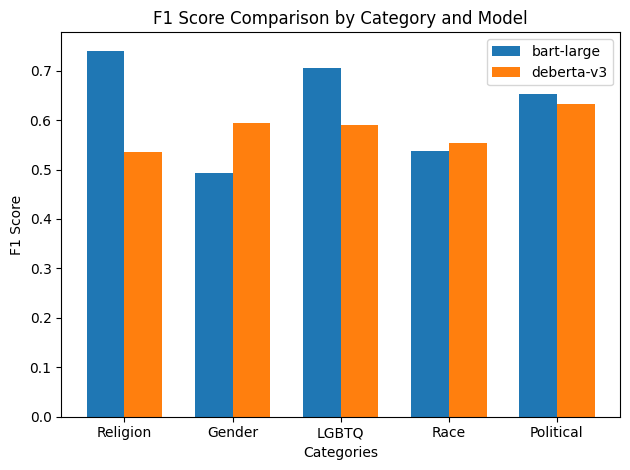

In [568]:

# List of categories
categories = ['Religion', 'Gender', 'LGBTQ', 'Race', 'Political']

# Accuracy results for BART and DeBERTa models
bart_results = [bart_results_religion_accuracy['f1'], bart_results_gender_accuracy['f1'], bart_results_lgbtq_accuracy['f1'], bart_results_race_accuracy['f1'], bart_results_political_accuracy['f1']]
deberta_results = [deberta_results_religion_accuracy['f1'], deberta_results_gender_accuracy['f1'], deberta_results_lgbtq_accuracy['f1'], deberta_results_race_accuracy['f1'], deberta_results_political_accuracy['f1']]

# Width of each bar
bar_width = 0.35

# Create a figure and axis
fig, ax = plt.subplots()

# Position of each bar group on the x-axis
x = range(len(categories))

# Plot the bars for BART and DeBERTa accuracy results
bart_bars = ax.bar(x, bart_results, bar_width, label='bart-large')
deberta_bars = ax.bar([i + bar_width for i in x], deberta_results, bar_width, label='deberta-v3')

# Set labels, title, and legend
ax.set_xlabel('Categories')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score Comparison by Category and Model')
ax.set_xticks([i + bar_width/2 for i in x])
ax.set_xticklabels(categories)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [457]:

def get_accuracy_results_rationale(df):
  
  true_positive_bias = len(df[df.apply(lambda row: 'entailment' in row['predicted'] and row['bias'] == 'bias', axis=1)])
  false_positive_bias = len(df[df.apply(lambda row: 'entailment' in row['predicted'] and row['bias'] == 'neutral', axis=1)])
  false_negative_bias = len(df[df.apply(lambda row: ('neutral' in row['predicted'] or 'contradiction' in row['predicted']) and row['bias'] == 'bias', axis=1)])

  precision_bias = true_positive_bias / (true_positive_bias + false_positive_bias + 1e-10)  # Adding a small constant
  recall_bias = true_positive_bias / (true_positive_bias + false_negative_bias + 1e-10)  # Adding a small constant
  f1_bias = (2 * precision_bias * recall_bias) / (precision_bias + recall_bias + 1e-10)  # Adding a small constant

  true_positive_neutral = len(df[df.apply(lambda row: ('neutral' in row['predicted'] or 'contradiction' in row['predicted']) and row['bias'] == 'neutral', axis=1)])
  false_positive_neutral = len(df[df.apply(lambda row: ('neutral' in row['predicted'] or 'contradiction' in row['predicted']) and row['bias'] == 'bias', axis=1)])
  false_negative_neutral = len(df[df.apply(lambda row: 'entailment' in row['predicted'] and row['bias'] == 'neutral', axis=1)])

  precision_neutral = true_positive_neutral / (true_positive_neutral + false_positive_neutral + 1e-10)  # Adding a small constant
  recall_neutral = true_positive_neutral / (true_positive_neutral + false_negative_neutral + 1e-10)  # Adding a small constant
  f1_neutral = (2 * precision_neutral * recall_neutral) / (precision_neutral + recall_neutral + 1e-10)  # Adding a small constant

  return ({
    'precision': (precision_bias + precision_neutral) / 2,
    'recall': (recall_bias + recall_neutral) / 2,
    'f1': (f1_bias + f1_neutral) / 2,
    'accuracy': (true_positive_bias + true_positive_neutral) / len(df)

  })
    


In [459]:
get_accuracy_results_rationale(bart_large_rationale)

{'precision': 0.1508759291529367,
 'recall': 0.1529999999999694,
 'f1': 0.15170975048060326,
 'accuracy': 0.153}

In [460]:
get_accuracy_results_rationale(deberta_base_rationale)

{'precision': 0.11288013160062285,
 'recall': 0.11499999999997701,
 'f1': 0.11378677404378049,
 'accuracy': 0.115}

In [461]:
get_accuracy_results_rationale(deberta_v3_rationale)

{'precision': 0.5472304088262411,
 'recall': 0.529999999999894,
 'f1': 0.48283223073159265,
 'accuracy': 0.53}

In [552]:
## totals


def get_prediction_breakdown(df, threshold=1):

  # lower threshold for indexing issues
  threshold = threshold - 1

  # Count occurrences of 'bias' and 'neutral' predictions
  total_bias = len(df[df.apply(lambda row: 'bias' in row['predicted'][threshold], axis=1)])
  total_neutral = len(df[df.apply(lambda row: 'neutral' in row['predicted'][threshold], axis=1)])

  return ({
    'Bias': total_bias,
    'Neutral':total_neutral
  })
    

print(get_prediction_breakdown(bart_results, 2))
print(get_prediction_breakdown(deberta_results, 1))

print(3234/(3234+2230))
print(2230/(3234+2230))

print(3030/(3030+2434))
print(2434/(3030+2434))




{'Bias': 3234, 'Neutral': 2230}
{'Bias': 3030, 'Neutral': 2434}
0.5918740849194729
0.4081259150805271
0.5545387994143485
0.44546120058565153
